In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, udf, mean, split, desc, min, max
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, PCA, StringIndexer, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd

1.Imports necessary PySpark SQL functions to handle and process data (col, mean, split, desc). 2.Defines data types (DoubleType, IntegerType) for numerical processing. 3.Loads ML features and preprocessing tools (VectorAssembler, StandardScaler, OneHotEncoder, PCA, etc.). 4.Includes machine learning models like RandomForestRegressor and RandomForestClassifier. 5.Implements model evaluatio(RegressionEvaluator) and clustering (BisectingKMeans). 6.Uses hyperparameter tuning (ParamGridBuilder, CrossValidator) for better model optimization. 7.Matplotlib and Pandas for data visualization and result analysis.

**Initialize Spark Session**

In [ ]:
spark = SparkSession.builder \
    .appName("FIFA18_PlayerPerformance") \
    .getOrCreate()


Load and Merge Datasets Loads multiple datasets in CSV format (spark.read.csv). Joins them on "ID" using inner join, ensuring only matching records are merged.Removes duplicate columns to avoid redundant data.Converts the dataframe from Spark to Pandas and back to Spark to handle duplicate removal.

In [17]:
# Load datasets
complete_df = spark.read.csv("/content/CompleteDataset.csv", header=True, inferSchema=True)
attribute_df = spark.read.csv("/content/PlayerAttributeData.csv", header=True, inferSchema=True)
personal_df = spark.read.csv("/content/PlayerPersonalData.csv", header=True, inferSchema=True)
position_df = spark.read.csv("/content/PlayerPlayingPositionData.csv", header=True, inferSchema=True)

# Join datasets using "ID" column
df = complete_df \
    .join(attribute_df, on="ID", how="inner") \
    .join(personal_df, on="ID", how="inner") \
    .join(position_df, on="ID", how="inner")
# Remove duplicate columns
df = df.toPandas()
df = df.loc[:, ~df.columns.duplicated()]
df = spark.createDataFrame(df)

# Print column count
print(f"Total number of columns: {len(df.columns)}")

Total number of columns: 76


**Handle Missing Values**

Handles salary values by removing currency symbols (€). Converts M (millions) and K (thousands) to numerical values.Registers User Defined Function (UDF) in Spark. Applies transformation to convert "Value" and "Wage" to numeric types.

In [18]:
# Function to convert monetary values (€105M → 105000000)
def convert_money(value):
    if value is None or value == "":
        return None
    value = value.replace("€", "").replace("M", "000000").replace("K", "000")
    return float(value)

# Register UDF
convert_money_udf = udf(convert_money, DoubleType())

# Apply transformations
df = df.withColumn("Value", convert_money_udf(col("Value")))
df = df.withColumn("Wage", convert_money_udf(col("Wage")))

df.select("Value", "Wage").show(10)

+------+--------+
| Value|    Wage|
+------+--------+
|  95.5|565000.0|
|1.05E8|565000.0|
|1.23E8|280000.0|
| 9.7E7|510000.0|
| 6.1E7|230000.0|
| 9.2E7|355000.0|
|  64.5|215000.0|
|  90.5|295000.0|
| 7.9E7|340000.0|
| 7.7E7|275000.0|
+------+--------+
only showing top 10 rows



Finds columns with values like "80-90". Splits the values into two numbers and computes the mean.Computes mean value for missing numerical columns and fills missing values.Finds most common (mode) value for missing categorical data and fills them.If more than 50% of values are missing, the column is dropped.

In [19]:
def fix_range_values(df):
    for column in df.columns:
        df = df.withColumn(column, when(
            col(column).rlike("^[0-9]+[-+][0-9]+$"),  # Check for "X-Y" or "X+Y" format
            (split(col(column), "[-+]").getItem(0).cast("int") +
             split(col(column), "[-+]").getItem(1).cast("int")) / 2  # Compute mean of values
        ).otherwise(col(column)))
    return df

In [20]:
df = fix_range_values(df)

In [21]:
def fill_missing_numerical(df):
    for column in df.columns:
        # Check if column is numeric
        if dict(df.dtypes)[column] in ['int', 'double']:
            mean_value = df.select(mean(col(column))).collect()[0][0]
            if mean_value is not None:  # Only fill if mean is valid
                df = df.fillna({column: mean_value})
    return df
def fill_missing_categorical(df):
    for column in df.columns:
        # Check if column is categorical (string type)
        if dict(df.dtypes)[column] == 'string':
            mode_row = df.groupBy(column).count().orderBy(desc("count")).first()

            if mode_row and mode_row[0] is not None:  # Check if mode exists
                df = df.fillna({column: mode_row[0]})
            else:
                df = df.fillna({column: "Unknown"})  # Fill with 'Unknown' if no mode found

    return df
def drop_high_missing_columns(df, threshold=0.5):
    total_rows = df.count()
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        if (missing_count / total_rows) > threshold:  # Drop if more than 50% missing
            df = df.drop(column)
    return df
df = fill_missing_numerical(df)
df = fill_missing_categorical(df)
df = drop_high_missing_columns(df)

**One-Hot Encoding Categorical Features**

Converts categorical variables into numerical labels using StringIndexer.Applies One-Hot Encoding to transform categorical columns into numerical vectors.

In [22]:
categorical_columns = ["Nationality", "Club", "Preferred Positions"]
indexed_columns = [col + "_index" for col in categorical_columns]
encoded_columns = [col + "_encoded" for col in categorical_columns]

indexers = [StringIndexer(inputCol=col, outputCol=idx_col, handleInvalid="keep") for col, idx_col in zip(categorical_columns, indexed_columns)]
encoders = [OneHotEncoder(inputCol=idx_col, outputCol=enc_col) for idx_col, enc_col in zip(indexed_columns, encoded_columns)]

pipeline = Pipeline(stages=indexers + encoders)
df = pipeline.fit(df).transform(df)


**Convert Numerical Columns from String to Double**

FIFA 18  dataset stores numerical attributes as strings (e.g., "78+" or "85-90"), which cannot be used directly in ML models.This step ensures all skill attributes are numerical so they can be processed correctly.

In [23]:
# Convert skill attributes from string to numerical
skill_columns = ["Acceleration", "Aggression", "Agility", "Balance", "Ball control", "Composure", "Crossing",
    "Curve", "Dribbling", "Finishing", "Free kick accuracy", "GK diving", "GK handling", "GK kicking",
    "GK positioning", "GK reflexes", "Heading accuracy", "Interceptions", "Jumping", "Long passing",
    "Long shots", "Marking", "Penalties", "Positioning", "Reactions", "Short passing", "Shot power",
    "Sliding tackle", "Sprint speed", "Stamina", "Standing tackle", "Strength", "Vision", "Volleys"]

for col_name in skill_columns:
    df = df.withColumn(col_name, regexp_replace(col(col_name), "[^0-9]", "").cast("double"))

In [24]:
feature_columns = [
    "Aggression", "Dribbling", "Balance", "Acceleration", "Composure", "Ball control",
    "Finishing", "Long passing", "Marking", "Positioning", "Reactions", "Short passing",
    "Shot power", "Sliding tackle", "Sprint speed", "Stamina", "Standing tackle", "Strength", "Vision","Nationality_encoded", "Club_encoded", "Preferred Positions_encoded"
]


**Normalization & Standardization**

Converts multiple individual numerical columns into a single feature vector.Brings all features to the same scale, preventing large-valued features from dominating.Improves model performance, especially for algorithms sensitive to magnitude differences.

In [25]:
# Drop previous predictions if exist
if "prediction" in df.columns:
    df = df.drop("prediction")
# Assemble features before normalization
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

# Apply MinMaxScaler for Normalization (scales values between 0 and 1)
scaler = MinMaxScaler(inputCol="features", outputCol="normalizedFeatures")
df = scaler.fit(df).transform(df)

# Apply StandardScaler for Standardization (zero mean and unit variance)
std_scaler = StandardScaler(inputCol="normalizedFeatures", outputCol="scaledFeatures", withMean=True, withStd=True)
df = std_scaler.fit(df).transform(df)

# Apply PCA for dimensionality reduction
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
df = pca.fit(df).transform(df)


**Hyperparameter tuning**

hyperparameter tuning for K-Means clustering using cross-validation to find the optimal number of clusters (k). The ParamGridBuilder defines different values of k (from 3 to 7), and ClusteringEvaluator evaluates clustering performance. The best model is selected using 3-fold cross-validation, and the optimal number of clusters (best_k) is extracted from the trained model.

In [26]:
kmeans = KMeans(featuresCol="pcaFeatures", seed=42)
paramGrid = (ParamGridBuilder()
             .addGrid(kmeans.k, [3, 4, 5, 6, 7])
             .build())

evaluator = ClusteringEvaluator(featuresCol="pcaFeatures")
cv = CrossValidator(estimator=kmeans, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cv_model = cv.fit(df)
df = cv_model.bestModel.transform(df)
best_k = cv_model.bestModel.summary.k

**Evaluation**

It evaluates the clustering performance by computing the Silhouette Score, which measures how well-separated the clusters are. It then identifies the smallest cluster (potential anomalies) by finding the cluster with the fewest data points. Finally, it filters and displays players in this smallest cluster, showing their name, overall rating, value, wage, and assigned cluster.

In [27]:
#  Get Best Silhouette Score
silhouette_score = evaluator.evaluate(df)
print(f"Best Number of Clusters: {best_k}")
print(f"Best Silhouette Score: {silhouette_score}")

#Find Anomalies in the Smallest Cluster
cluster_counts = df.groupBy("prediction").count()
min_cluster = cluster_counts.orderBy("count").first()["prediction"]
anomalies = df.filter(col("prediction") == min_cluster)
anomalies.select("Name", "Overall", "Value", "Wage", "prediction").show(10)

Best Number of Clusters: 4
Best Silhouette Score: 0.7144152632914653
+-------------+-------+---------+--------+----------+
|         Name|Overall|    Value|    Wage|prediction|
+-------------+-------+---------+--------+----------+
|   M. Dembélé|   83.0|    2.5E7|115000.0|         3|
|  B. Ivanović|   82.0|9000000.0| 73000.0|         3|
|    M. Sanson|   81.0|    2.4E7| 34000.0|         3|
|    D. Lovren|   81.0|     17.5|110000.0|         3|
|T. Stepanenko|   80.0|    1.4E7|  1000.0|         3|
|   L. Paredes|   79.0|     16.5| 64000.0|         3|
|    V. Darida|   79.0|     14.5| 38000.0|         3|
| I. Smolnikov|   79.0|    1.0E7| 71000.0|         3|
|     S. Tasci|   79.0|      9.5| 67000.0|         3|
|  M. Fellaini|   79.0|    1.2E7|140000.0|         3|
+-------------+-------+---------+--------+----------+
only showing top 10 rows



**visualization of Anomalies**

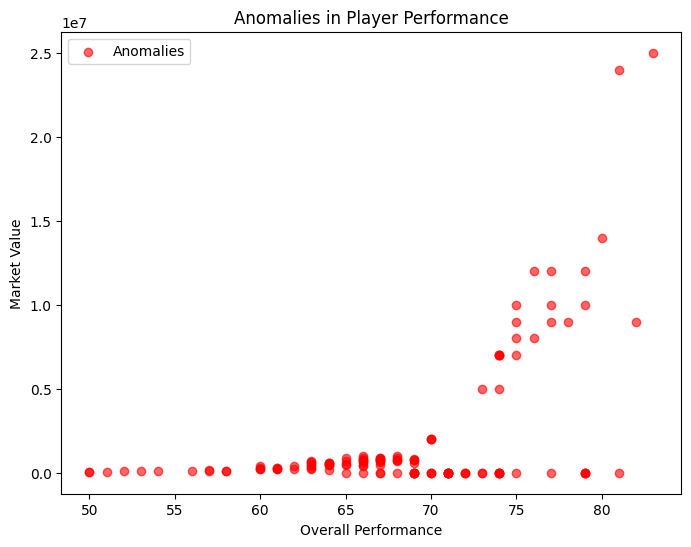

In [28]:
# Visualize Anomalies
predictions_pd = anomalies.select("Overall", "Value", "Wage").toPandas()
plt.figure(figsize=(8, 6))
plt.scatter(predictions_pd["Overall"], predictions_pd["Value"], color='red', alpha=0.6, label="Anomalies")
plt.xlabel("Overall Performance")
plt.ylabel("Market Value")
plt.title("Anomalies in Player Performance")
plt.legend()
plt.show()

This scatter plot highlights anomalies in player performance by comparing Overall Performance with Market Value, where red points indicate detected outliers. Most players exhibit a proportional relationship between performance and market value, but some anomalies deviate significantly. Overvalued players, with high market value despite moderate performance, suggest market hype or financial influence, while undervalued players could be hidden gems for scouting. The flat-lining of market value at lower performance levels suggests potential data inconsistencies or undervaluation trends. This analysis aids clubs and analysts in identifying market inefficiencies, helping them make informed transfer and investment decisions.